In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# external package

# NLP  
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


#To load the data
from utils import load_data

from preprocessing import prep_monthly_sales_by_country, prep_top5_total_sales_by_country
from preprocessing import focus_on_uk, generate_keywords


from visualizing import plot_monthly_sales_by_country, plot_top5_total_sales_by_country


In [2]:
data = load_data()


Current Working Directory: /home/rhycha/Desktop/_Drawer/_Missions/W2024-courses/datascience/ecommerce-transaction-data-analysis/app/src


In [3]:

# Download required NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

# Apply preprocessing to the Description column
data['ProcessedDescription'] = data['Description'].astype(str).apply(preprocess_text)

# Display the first few rows of the dataframe to verify preprocessing
data[['Description', 'ProcessedDescription']].head()


[nltk_data] Downloading package punkt to /home/rhycha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/rhycha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/rhycha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Description,ProcessedDescription
0,WHITE HANGING HEART T-LIGHT HOLDER,"[white, hanging, heart, tlight, holder]"
1,WHITE METAL LANTERN,"[white, metal, lantern]"
2,CREAM CUPID HEARTS COAT HANGER,"[cream, cupid, heart, coat, hanger]"
3,KNITTED UNION FLAG HOT WATER BOTTLE,"[knitted, union, flag, hot, water, bottle]"
4,RED WOOLLY HOTTIE WHITE HEART.,"[red, woolly, hottie, white, heart]"


In [4]:
import re
from collections import Counter

# Define a list of stopwords
stop_words = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
    'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
    'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
    'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
    'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
    'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
    'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
    'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
    'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
    'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
    'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now'
])

# Function to preprocess text
def preprocess_text_manual(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize text
    tokens = text.split()
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Apply preprocessing to the Description column
data['ProcessedDescription'] = data['Description'].astype(str).apply(preprocess_text_manual)

# Flatten the list of lists and count word frequencies
all_words = [word for sublist in data['ProcessedDescription'] for word in sublist]
word_freq = Counter(all_words)

# Display the most common words
word_freq.most_common(10)


[('set', 63845),
 ('bag', 51911),
 ('red', 42902),
 ('heart', 39163),
 ('retrospot', 35126),
 ('vintage', 33748),
 ('design', 30066),
 ('pink', 29526),
 ('christmas', 25131),
 ('box', 24469)]

In [5]:
# Ensure InvoiceDate is in datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Extract year and month from InvoiceDate
data['YearMonth'] = data['InvoiceDate'].dt.to_period('M')

# Define the top keywords to track
top_keywords = ['set', 'bag', 'red', 'heart', 'retrospot', 'vintage', 'design', 'pink', 'christmas', 'box']

# Initialize a dictionary to store keyword frequencies by month
keyword_trends = {keyword: [] for keyword in top_keywords}

# Get a list of unique YearMonth values
unique_months = data['YearMonth'].unique()

# Calculate keyword frequencies for each month
for month in unique_months:
    # Filter data for the current month
    monthly_data = data[data['YearMonth'] == month]
    # Flatten the list of processed descriptions for the current month
    all_words_month = [word for sublist in monthly_data['ProcessedDescription'] for word in sublist]
    word_freq_month = Counter(all_words_month)
    # Store the frequency of each top keyword for the current month
    for keyword in top_keywords:
        keyword_trends[keyword].append(word_freq_month[keyword])

# Convert the keyword trends to a DataFrame for easier plotting
keyword_trends_df = pd.DataFrame(keyword_trends, index=unique_months).sort_index()

# Display the keyword trends DataFrame
keyword_trends_df.head()


,set,bag,red,heart,retrospot,vintage,design,pink,christmas,box
2010-12,3970,2585,3641,3226,2863,1907,2020,2235,2722,2308
2011-01,4263,2669,3112,3291,2705,1441,1822,2611,399,1721
2011-02,3199,2128,2610,2310,2358,1070,1609,1845,102,1272
2011-03,4165,3159,3121,2262,2877,1463,2173,2446,88,1732
2011-04,3058,2870,2483,1850,2290,1256,1818,1992,76,1250


In [6]:
# Extract year and month from InvoiceDate
data['YearMonth'] = data['InvoiceDate'].dt.to_period('M')

# Define the top keywords to track
top_keywords = ['set', 'bag', 'red', 'heart', 'retrospot', 'vintage', 'design', 'pink', 'christmas', 'box']

# Initialize a dictionary to store keyword frequencies by month
keyword_trends = {keyword: [] for keyword in top_keywords}
keyword_trends['YearMonth'] = []

# Get a list of unique YearMonth values
unique_months = data['YearMonth'].unique()

# Calculate keyword frequencies for each month
for month in unique_months:
    # Filter data for the current month
    monthly_data = data[data['YearMonth'] == month]
    # Flatten the list of processed descriptions for the current month
    all_words_month = [word for sublist in monthly_data['ProcessedDescription'] for word in sublist]
    word_freq_month = Counter(all_words_month)
    # Store the frequency of each top keyword for the current month
    for keyword in top_keywords:
        keyword_trends[keyword].append(word_freq_month[keyword])
    # Store the current month
    keyword_trends['YearMonth'].append(month)

# Convert the keyword trends to a DataFrame for easier plotting
keyword_trends_df = pd.DataFrame(keyword_trends)

# Display the keyword trends DataFrame
keyword_trends_df.head()


,set,bag,red,heart,retrospot,vintage,design,pink,christmas,box,YearMonth
0,3970,2585,3641,3226,2863,1907,2020,2235,2722,2308,2010-12
1,4263,2669,3112,3291,2705,1441,1822,2611,399,1721,2011-01
2,3199,2128,2610,2310,2358,1070,1609,1845,102,1272,2011-02
3,4165,3159,3121,2262,2877,1463,2173,2446,88,1732,2011-03
4,3058,2870,2483,1850,2290,1256,1818,1992,76,1250,2011-04


In [7]:
# Ensure InvoiceDate is in datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Extract year and month from InvoiceDate
data['YearMonth'] = data['InvoiceDate'].dt.to_period('M')

# Display the first few rows to verify the YearMonth column
data[['InvoiceDate', 'YearMonth']].head()


,InvoiceDate,YearMonth
0,2010-12-01 08:26:00,2010-12
1,2010-12-01 08:26:00,2010-12
2,2010-12-01 08:26:00,2010-12
3,2010-12-01 08:26:00,2010-12
4,2010-12-01 08:26:00,2010-12


In [8]:
# Take a subset of the data for simplicity (e.g., first 100 rows)
subset_data = data.head(100)

# Ensure InvoiceDate is in datetime format for the subset
subset_data['InvoiceDate'] = pd.to_datetime(subset_data['InvoiceDate'])

# Extract year and month from InvoiceDate
subset_data['YearMonth'] = subset_data['InvoiceDate'].dt.to_period('M')

# Display the first few rows to verify the YearMonth column in the subset
subset_data[['InvoiceDate', 'YearMonth']].head()


/tmp/ipykernel_37420/2334377667.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data['InvoiceDate'] = pd.to_datetime(subset_data['InvoiceDate'])
/tmp/ipykernel_37420/2334377667.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data['YearMonth'] = subset_data['InvoiceDate'].dt.to_period('M')


,InvoiceDate,YearMonth
0,2010-12-01 08:26:00,2010-12
1,2010-12-01 08:26:00,2010-12
2,2010-12-01 08:26:00,2010-12
3,2010-12-01 08:26:00,2010-12
4,2010-12-01 08:26:00,2010-12


Current Working Directory: /home/rhycha/Desktop/_Drawer/_Missions/W2024-courses/datascience/ecommerce-transaction-data-analysis/app/src


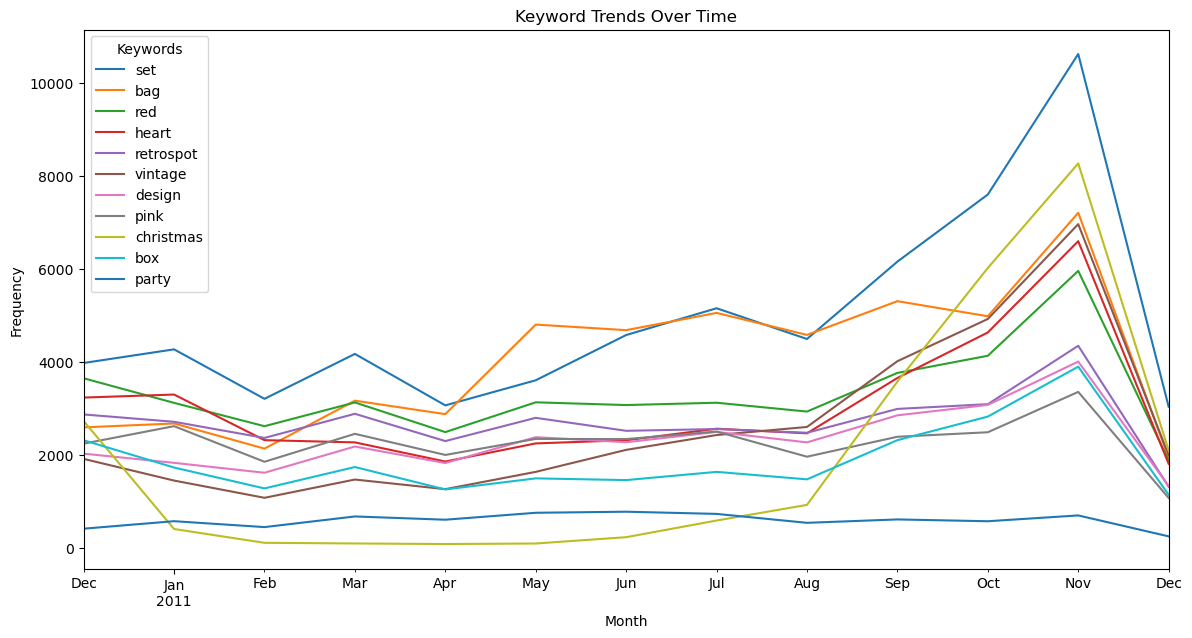

In [9]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt

# Load the dataset
data = load_data()

# Ensure InvoiceDate is in datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Extract year and month from InvoiceDate
data['YearMonth'] = data['InvoiceDate'].dt.to_period('M')

# Define a list of stopwords
stop_words = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
    'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
    'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
    'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
    'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
    'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
    'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
    'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
    'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
    'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
    'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now'
])

# Function to preprocess text
def preprocess_text_manual(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize text
    tokens = text.split()
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Apply preprocessing to the Description column
data['ProcessedDescription'] = data['Description'].astype(str).apply(preprocess_text_manual)

# Define the top keywords to track
top_keywords = ['set', 'bag', 'red', 'heart', 'retrospot', 'vintage', 'design', 'pink', 'christmas', 'box']

# Initialize a dictionary to store keyword frequencies by month
keyword_trends = {keyword: [] for keyword in top_keywords}
keyword_trends['YearMonth'] = []

# Get a list of unique YearMonth values
unique_months = data['YearMonth'].unique()

# Calculate keyword frequencies for each month
for month in unique_months:
    # Filter data for the current month
    monthly_data = data[data['YearMonth'] == month]
    # Flatten the list of processed descriptions for the current month
    all_words_month = [word for sublist in monthly_data['ProcessedDescription'] for word in sublist]
    word_freq_month = Counter(all_words_month)
    # Store the frequency of each top keyword for the current month
    for keyword in top_keywords:
        keyword_trends[keyword].append(word_freq_month[keyword])
    # Store the current month
    keyword_trends['YearMonth'].append(month)

# Convert the keyword trends to a DataFrame for easier plotting
keyword_trends_df = pd.DataFrame(keyword_trends)

# Plotting the trends
keyword_trends_df.set_index('YearMonth', inplace=True)
keyword_trends_df.plot(figsize=(14, 7))
plt.title('Keyword Trends Over Time')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.legend(title='Keywords')
plt.show()
